In [1]:
from Startup import *

finished standard imports
dict_items([('spark.executor.cores', '1'), ('spark.logConf', 'True'), ('spark.cores.max', '4'), ('spark.app.name', 'Weather_PCA'), ('spark.executor.memory', '3g'), ('spark.default.parallelism', '10')])
started SparkContext and SQLContext in 13.04 seconds
loaded weather.parquet in 7.59 seconds
loaded stations.parquet in 0.22 seconds
registered dataframes as tables in 0.19 seconds


In [2]:
%%time
allData = sqlContext.sql("SELECT * FROM parquet.`s3://philipp-ghcnd/GHCNDall.parquet`")
allData.createOrReplaceTempView("ghcnd")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.93 s


In [3]:
%%time
qry = """
SELECT CAST(SUBSTRING(year_date, 1, 4) AS INT) AS year, 
       COUNT(element) AS count
FROM ghcnd
WHERE element='WT08' 
      AND SUBSTRING(year_date, 5, 8)<>'0229' 
      AND SUBSTRING(id, 1, 2)='US' 
      AND CAST(SUBSTRING(year_date, 1, 4) AS INT)>1959
GROUP BY SUBSTRING(year_date, 1, 4)
ORDER BY SUBSTRING(year_date, 1, 4) ASC"""
counts = sqlContext.sql(qry)

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 197 ms


CPU times: user 212 ms, sys: 0 ns, total: 212 ms
Wall time: 1min 40s


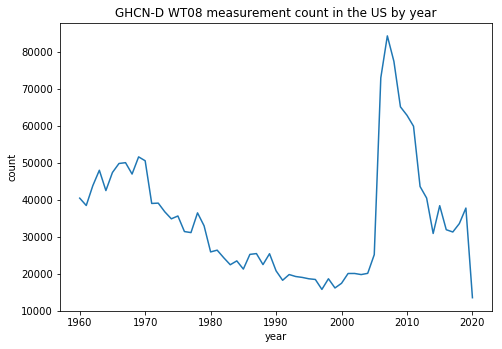

In [4]:
%%time
allyears = counts.select('year').collect()
allcounts = counts.select('count').collect()
from matplotlib import pyplot as plt
%matplotlib inline
fig1 = plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
ax1.plot(allyears, allcounts)
ax1.set_title('GHCN-D WT08 measurement count in the US by year')
ax1.set_ylabel('count')
ax1.set_xlabel('year')

In [5]:
%%time
qry = """
SELECT *
FROM ghcnd
WHERE element='WT08'
"""
wt08alldata = sqlContext.sql(qry)
wt08alldata.createOrReplaceTempView("ghcnd_WT08")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 19.5 ms


In [6]:
%%time
qry = """
SELECT id AS Station,
       CAST(SUBSTRING(year_date, 1, 4) AS SMALLINT) AS year,
       DAYOFYEAR(TO_DATE(year_date,'yyyyMMdd')) AS day,
       TO_DATE(year_date,'yyyyMMdd') AS date,
       NOT ISNULL(TO_DATE(CONCAT(SUBSTRING(year_date, 1, 4), '0229'),'yyyyMMdd')) AS isleapyear,
       CAST(data_value AS tinyint) AS Value
FROM ghcnd_WT08
WHERE SUBSTRING(id, 1, 2)='US' 
      AND CAST(SUBSTRING(year_date, 1, 4) AS SMALLINT)>1959
      AND SUBSTRING(year_date, 5, 8)<>'0229'
ORDER BY SUBSTRING(year_date, 1, 4) ASC"""
wt08data = sqlContext.sql(qry)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 82 ms


In [7]:
%%time
WT08_pdf = wt08data.toPandas()

CPU times: user 16.9 s, sys: 500 ms, total: 17.4 s
Wall time: 1min 49s


In [8]:
%%time
def fillVals(row):
    days = np.array(row['days']) - 1
    if row['isleapyear']:
        days[days>59] -= 1
    vals = np.zeros(365,dtype = int)
    vals[days] = 1
    return list(vals)

statyrday = (WT08_pdf.groupby(['Station','year','isleapyear'])
       .apply(lambda x: list(x.day))
       .reset_index(name='days'))
statyrday['Values'] = statyrday.apply(fillVals, axis=1)
wt08 = statyrday.drop(['days','isleapyear'],1)
wt08.head(5)

CPU times: user 6.44 s, sys: 76 ms, total: 6.52 s
Wall time: 6.51 s


In [ ]:
%%time
df = sqlContext.createDataFrame(wt08.astype(str))
df.write.parquet("s3://philipp-ghcnd/GHCND_WT08_1960_2020_US.parquet")